In [1]:
# Reference taken from:- https://github.com/udacity/deep-learning-v2-pytorch/blob/master/weight-initialization/weight_initialization_exercise.ipynb

# Importing the libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Defining a three-layer neural network

class SimpleNN(nn.Module):
    def __init__(self, d, d1, d2, k, weight_init='random'):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(d, d1)
        self.fc2 = nn.Linear(d1, d2)
        self.fc3 = nn.Linear(d2, k)

        # Using different weight initialization where weights initialized to 0 and randomly between -1 and 1.

        if weight_init == 'zero':
            nn.init.constant_(self.fc1.weight, 0)
            nn.init.constant_(self.fc2.weight, 0)
            nn.init.constant_(self.fc3.weight, 0)
        elif weight_init == 'random':
            nn.init.uniform_(self.fc1.weight, -1, 1)
            nn.init.uniform_(self.fc2.weight, -1, 1)
            nn.init.uniform_(self.fc3.weight, -1, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

In [3]:
# Creating the function to train the model

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        data = data.view(data.size(0), -1).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(train_loader)

In [4]:
# Creating the function for validating the model

def validate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1).to(device)
            target = target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [5]:
# Setting the hyperparameters for the neural networks

d = 784  # The Input dimension will be based on the size of the input which is 28 in this case
d1 = 300 # As specified in the problem
d2 = 200 # As specified in the problem
k = 10
learning_rate = 0.01
num_epochs = 5
batch_size = 64

# Checking if the GPU is available or not

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading the MNIST dataset and Creating the Data Loaders

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Initialization: zero, Epoch [1/5] - Train Loss: 2.3021, Test Loss: 0.0361, Test Accuracy: 11.35%
Initialization: zero, Epoch [2/5] - Train Loss: 2.3015, Test Loss: 0.0361, Test Accuracy: 11.35%
Initialization: zero, Epoch [3/5] - Train Loss: 2.3013, Test Loss: 0.0361, Test Accuracy: 11.35%
Initialization: zero, Epoch [4/5] - Train Loss: 2.3013, Test Loss: 0.0361, Test Accuracy: 11.35%
Initialization: zero, Epoch [5/5] - Train Loss: 2.3013, Test Loss: 0.0361, Test Accuracy: 11.35%
Initialization: random, Epoch [1/5] - Train Loss: 2.3164, Test Loss: 0.0360, Test Accuracy: 14.37%
Initialization: random, Epoch [2/5] - Train Loss: 2.2377, Test Loss: 0.0346, Test Accuracy: 25.30%
Initialization: random, Epoch [3/5] - Train Loss: 2.1981, Test Loss: 0.0343, Test Accuracy: 26.93%
Initialization: random, Epoch [4/5] - Train Loss: 2.1800, Test Loss: 0.0340, Test Accuracy: 28.63%
Initialization: random, Epoch [5/5] - Train Loss: 2.1606, Test Loss: 0.0337, Test Accuracy: 31.25%


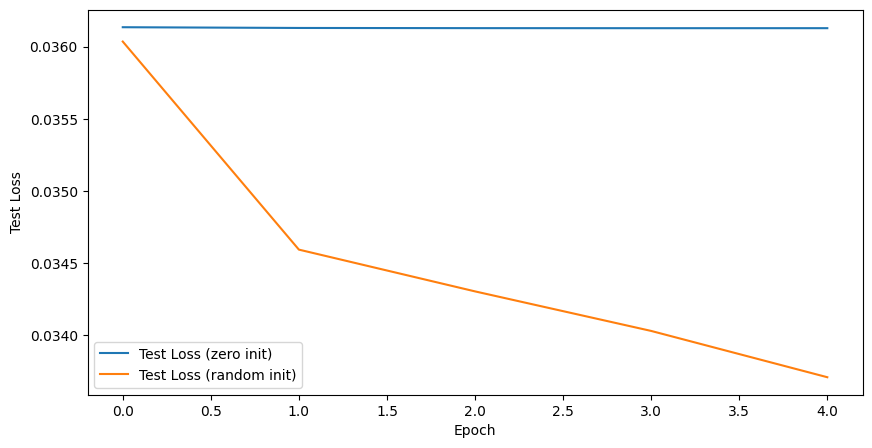

In [6]:
# Initialize with different weight initialization methods

results = {}

# Using the two conditions given in the question for weight initialization

for weight_init in ['zero', 'random']:
    model = SimpleNN(d, d1, d2, k, weight_init).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_accuracy = validate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Initialization: {weight_init}, Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.2f}%")

    results[weight_init] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

# Plot

plt.figure(figsize=(10, 5))

for weight_init, data in results.items():
    plt.plot(data['test_losses'], label=f'Test Loss ({weight_init} init)')

plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.legend()
plt.show()